Задача - прогнозирование стоимости недвижимости
В эпоху постоянных изменений, когда цены на недвижимость растут быстрее, чем заработные платы, люди стремятся найти наиболее рациональный способ извлечь максимальную выгоду, затратив минимум средств. Понимание факторов, влияющих на ценообразование, имеет чрезвычайно важное значение для получения конкурентных преимуществ и выгоды, и сфера недвижимости не является исключением.

К вам обратился заказчик, желающий построить систему ценообразования объектов недвижимости, и для начала он хотел бы получить модель для предсказания стоимости жилья на основе объявлений о продаже.

В частности необходимо:

построить модель, предсказывающую цену недвижимости в объявлении (price)
обосновать решения, принятые вами в процессе моделирования
интепретировать полученные результаты для заказчика.
Расширение датасета новыми признаками на основе открытых гео-данных приветствуется.

Описание данных
Вам дан датасет объявлений о продаже квартир в Москве и МО

Описание столбцов:

product_name - наименование объекта недвижимости-
period - дата
postcode - почтовый индекс
address_name - адрес объекта
lat - координаты (широта)
lon - координаты (долгота)
object_type - тип объекта
total_square - общая площадь
rooms - количество комнат
floor - этаж
city - город
settlement - населенный пункт
district - район
area - микрорайон
description - текст объявления
source - источник
Формат представления решения
В качестве выполненного задания должен быть представлен github-репозиторий с воспроизводимыми .ipynb файлами или .py скриптами.

In [1]:
#импортируем важные для нашей работы библиотеки
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
        
from tqdm import tqdm_notebook as tqdmn  #базовый пакет с индикатором прогресса
from geopy.distance import geodesic 


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

In [3]:
#фиксируем параметры псевдослучайного генератора
seed = 42
random.seed(seed)
np.random.seed(seed)

In [263]:
#Загружаем датасет
df = pd.read_csv('realty_data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   period        0 non-null      float64
 2   price         98822 non-null  int64  
 3   postcode      93675 non-null  float64
 4   address_name  98821 non-null  object 
 5   lat           98822 non-null  float64
 6   lon           98822 non-null  float64
 7   object_type   98822 non-null  object 
 8   total_square  98822 non-null  float64
 9   rooms         94840 non-null  float64
 10  floor         98822 non-null  float64
 11  city          91928 non-null  object 
 12  settlement    6894 non-null   object 
 13  district      75111 non-null  object 
 14  area          19498 non-null  object 
 15  description   98573 non-null  object 
 16  source        98822 non-null  object 
dtypes: float64(7), int64(1), object(9)
memory usage: 12.8+ MB


Загрузка и изучение датасета, оценка его размера и наличие в нём пропусков

In [122]:
df.shape

(98822, 17)

In [5]:
df.isna().sum()

product_name        0
period          98822
price               0
postcode         5147
address_name        1
lat                 0
lon                 0
object_type         0
total_square        0
rooms            3982
floor               0
city             6894
settlement      91928
district        23711
area            79324
description       249
source              0
dtype: int64

Для наглядности построим тепловую карту пропущенных значений 

<Axes: >

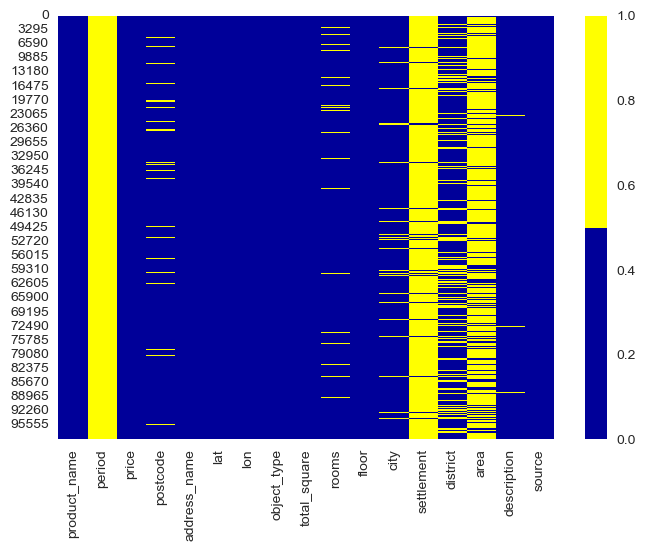

In [217]:
cols = df.columns[:]
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [123]:
df.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик


# Подготовка и очистка данных

Из столбца product_name вытащила наименование квартиры

In [264]:
df['name'] = [x.split(',',1)[0] for x in df['product_name']]

Столбец rooms имеет много пропущенных значений. 

In [265]:
df[df['rooms'].isna()]['name'].value_counts()

Студия      3330
Квартира     652
Name: name, dtype: int64

Видим,что в поле rooms много пропущенных значений, но в поле name они заполнены как Студия и Квартира, я решила заменить NAN  где в столбце name Студия

In [266]:
df['rooms'].where(~(pd.isna(df.rooms)& (df.name=="Студия")), other=0, inplace=True)


После замены NAN на 0,где в столбце name , осталось 652 пропущенных значения

In [267]:
df.rooms.isna().sum()

652

Из столбца description берем значение "Студия", все квартиры- студии будут размечены

In [268]:
df['description']=df['description'].str.lower()
df['description']=df['description'].str.replace("-"," ")
df['description_new'] = [x.split(' ') for x in df['description'].apply(str)]
def st_f(x):
    if "студия" in x:
       return  1
df['studia']=df.description_new.apply(st_f)
df.studia.value_counts()

1.0    6100
Name: studia, dtype: int64

In [269]:
df['rooms'].where(~(pd.isna(df.rooms)& (df.studia==1)), other=0, inplace=True)

In [270]:
df['rooms'].isna().sum()

396

Пропушенные значения в столбце rooms составляют около 0.4% ,поэтому решаю удалить эти строки

In [271]:
df = df[~np. isnan (df.rooms)]

In [272]:
#Не несет информтивную нагрузку,необходимо удалить
df['object_type'].value_counts()

Квартира    98426
Name: object_type, dtype: int64

In [137]:
df.columns

Index(['product_name', 'period', 'price', 'postcode', 'address_name', 'lat',
       'lon', 'object_type', 'total_square', 'rooms', 'floor', 'city',
       'settlement', 'district', 'area', 'description', 'source', 'name',
       'description_new', 'studia'],
      dtype='object')

In [273]:
#удалим лишние столбцы,которые не несут важной информации для анализа
df=df.drop(columns=['product_name','period','object_type','postcode','address_name','studia','description_new','source','description'])


Объединила 2 столбца city и settlement location и сделала 2 столбца дополнительно для идентификации города или поселка

In [274]:
df['location']=np.where(pd.isna(df.city), df.settlement,df.city )
df['city_from']=np.where(pd.isna(df.city), 0,1)
df['settlement_from']=np.where(pd.isna(df.settlement), 0,1)

In [275]:
df.head()

,price,lat,lon,total_square,rooms,floor,city,settlement,district,area,name,location,city_from,settlement_from
0,63000000,55.778894,37.608844,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,3-комнатная,Москва,1,0
1,3250000,55.551025,37.313054,16.7,0.0,1.0,Москва,NaN,Филимонковское поселение,NaN,Студия,Москва,1,0
2,16004680,55.594802,37.431264,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,3-комнатная,Москва,1,0
3,7841776,55.594332,37.428099,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,1-комнатная,Москва,1,0
4,120000000,55.721097,37.464342,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,3-комнатная,Москва,1,0


In [276]:
df.isna().sum()

price                  0
lat                    0
lon                    0
total_square           0
rooms                  0
floor                  0
city                6887
settlement         91539
district           23701
area               78935
name                   0
location               0
city_from              0
settlement_from        0
dtype: int64

Добавляем столбец distance

In [277]:
#Задаем широту и долготу центра города и рассчитываем для каждой квартиры расстояние от центра.За центр города я Красную Площадь г. Москвы
city_center_coordinates = [55.753544, 37.621202]
df['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).kilometers, df['lat'], df['lon']))
df['distance'] = df['distance'].round(1)


In [278]:
df.head()

,price,lat,lon,total_square,rooms,floor,city,settlement,district,area,name,location,city_from,settlement_from,distance
0,63000000,55.778894,37.608844,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,3-комнатная,Москва,1,0,2.9
1,3250000,55.551025,37.313054,16.7,0.0,1.0,Москва,NaN,Филимонковское поселение,NaN,Студия,Москва,1,0,29.7
2,16004680,55.594802,37.431264,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,3-комнатная,Москва,1,0,21.3
3,7841776,55.594332,37.428099,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,1-комнатная,Москва,1,0,21.5
4,120000000,55.721097,37.464342,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,3-комнатная,Москва,1,0,10.5


In [279]:
df['price_of_metr']=df['price']/df['total_square']

Построим тепловую карту , для определения корреляции признаков

C:\Users\HP\AppData\Local\Temp\ipykernel_11876\785047201.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Corr=df.corr()


<Axes: >

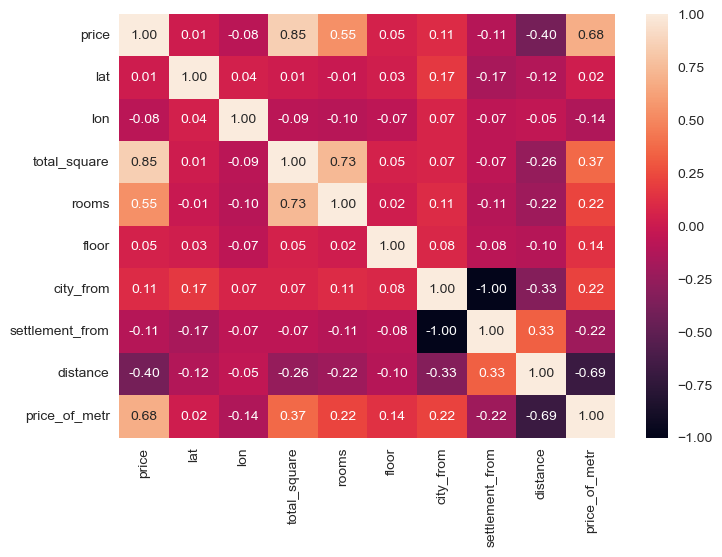

In [231]:
Corr=df.corr()
sns.heatmap(Corr, annot=True, fmt='.2f')

Видим,что цена коррелирует с общей площадью и количеством комнат

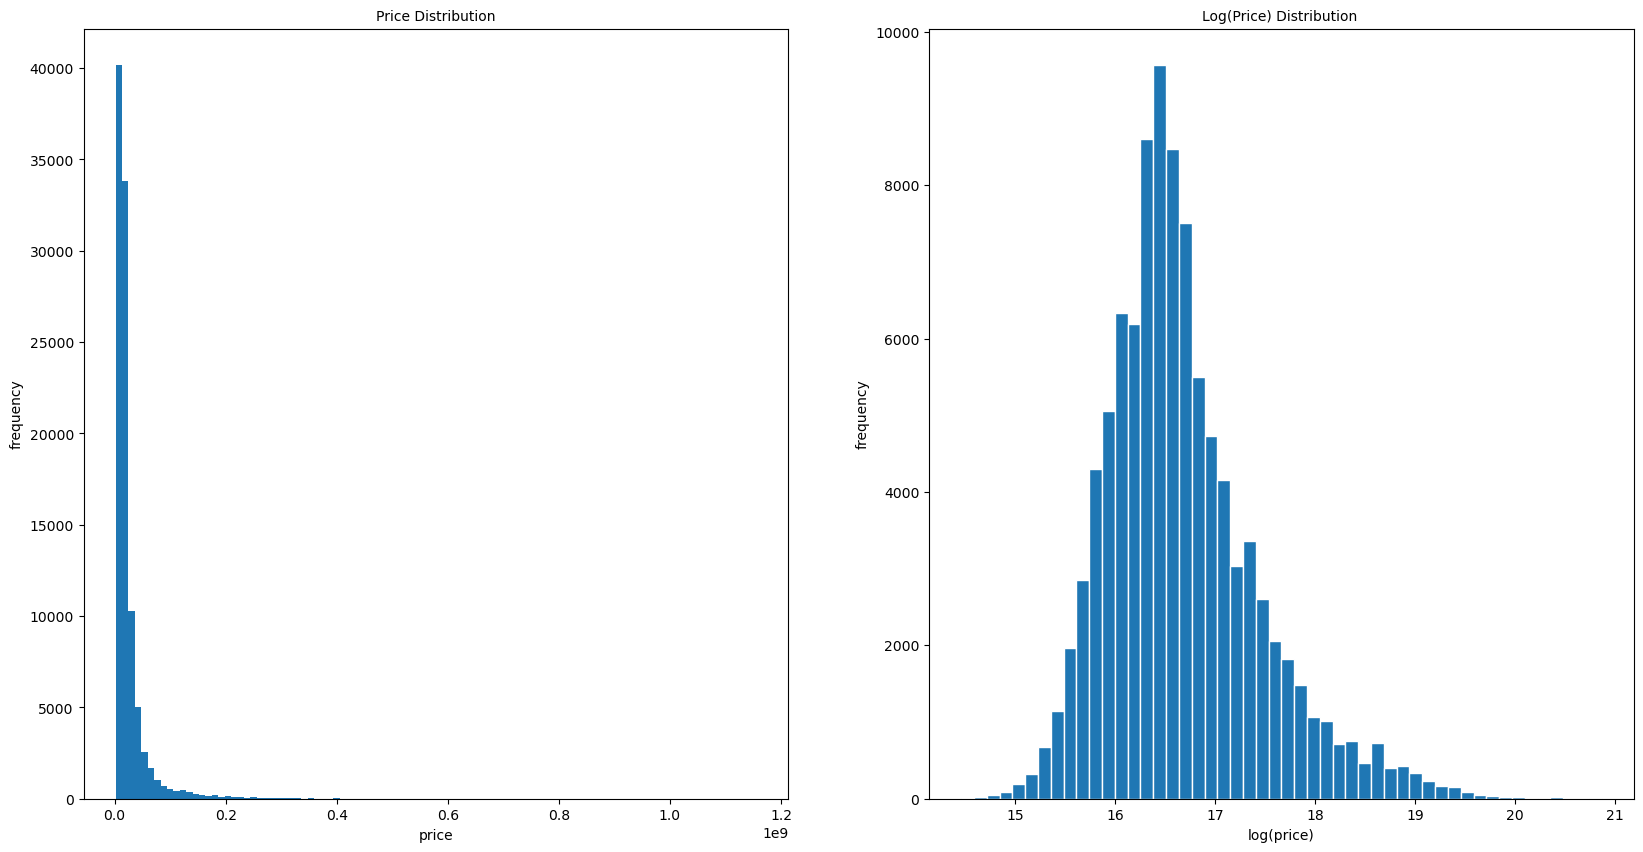

In [83]:
plt.subplot(1, 2,1)
(df['price']).plot.hist(bins=100) #, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.tick_params(labelsize=10)
plt.title('Price Distribution', fontsize=10)
# попробуем справится с хвостом , прологорифмируем y
plt.subplot(1, 2, 2)
np.log(df['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price)', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.tick_params(labelsize=10)
plt.title('Log(Price) Distribution ', fontsize=10)
plt.show()

In [180]:
df.shape

(98426, 12)

In [280]:
#Вычисляем строки со значениями-выбросами 
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = df[(df > (third_quartile + 1.5 * IQR)) | (df < (first_quartile - 1.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)


outliers = outliers.head()
df.drop(outliers.index, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_11876\1729261854.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  first_quartile = df.quantile(q=0.25)
C:\Users\HP\AppData\Local\Temp\ipykernel_11876\1729261854.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  third_quartile = df.quantile(q=0.75)
C:\Users\HP\AppData\Local\Temp\ipykernel_11876\1729261854.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = df[(df > (third_quartile + 1.5 * IQR)) | (df < (first_quar

In [146]:
df.isna().sum()

price                  0
lat                    0
lon                    0
total_square           0
rooms                  0
floor                  0
city                6882
settlement         91539
district           23696
area               78930
name                   0
location               0
city_from              0
settlement_from        0
distance               0
price_of_metr          0
dtype: int64

In [147]:
df.head()

,price,lat,lon,total_square,rooms,floor,city,settlement,district,area,name,location,city_from,settlement_from,distance,price_of_metr
0,63000000,55.778894,37.608844,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,3-комнатная,Москва,1,0,2.9,459854.014599
1,3250000,55.551025,37.313054,16.7,0.0,1.0,Москва,NaN,Филимонковское поселение,NaN,Студия,Москва,1,0,29.7,194610.778443
2,16004680,55.594802,37.431264,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,3-комнатная,Москва,1,0,21.3,210587.894737
3,7841776,55.594332,37.428099,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,1-комнатная,Москва,1,0,21.5,326740.666667
4,120000000,55.721097,37.464342,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,3-комнатная,Москва,1,0,10.5,952380.952381


city      rooms
Балашиха  0.0      4.681117e+06
          1.0      6.233417e+06
          2.0      8.702446e+06
          3.0      1.180669e+07
          4.0      1.383308e+07
Name: price, dtype: float64

#  Графический анализ

In [290]:
df['rooms'].value_counts().head(7)

2.0    34277
1.0    26938
3.0    24883
4.0     6377
0.0     3586
5.0     1618
6.0      649
Name: rooms, dtype: int64

In [291]:
df['name'].value_counts().head(7)

2-комнатная    34277
3-комнатная    24883
1-комнатная    23859
Студия          6409
4-комнатная     6377
5-комнатная     1618
6-комнатная      649
Name: name, dtype: int64

In [292]:
rooms_count=df['name'].value_counts().head(7)

In [293]:
#Заметила ,что при создании объявления в названии указано,как студия,а в количестве комнат указано,как однокомнатная.Решила исправить
df['rooms']=np.where(df['name']=='Студия',0,df['rooms'])

C:\Users\HP\AppData\Local\Temp\ipykernel_11876\3408084673.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


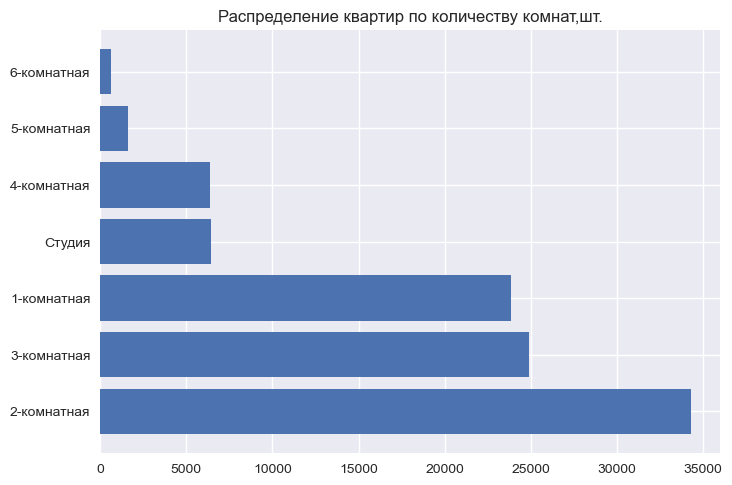

In [152]:
plt.style.use('seaborn')
plt.barh(rooms_count.index, rooms_count.values)
plt.title('Распределение квартир по количеству комнат,шт.')
plt.show()

In [234]:
location_count=df['city'].value_counts().head(10)

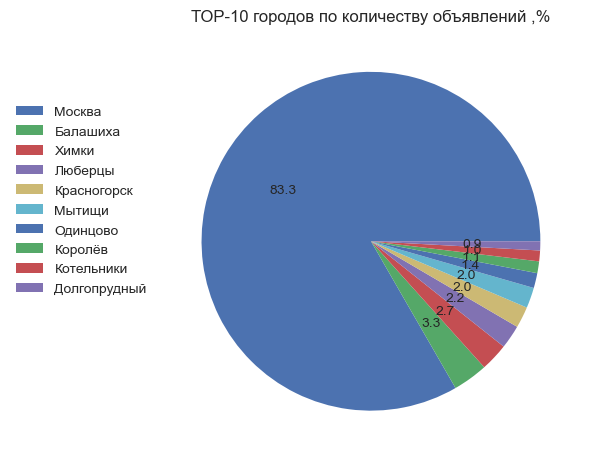

In [51]:
plt.pie(location_count.values, autopct='%.1f')
plt.legend(bbox_to_anchor = (-0.25, 0.60, 0.25, 0.25), labels = location_count.index)
plt.title('ТОР-10 городов по количеству объявлений ,%')
plt.show()

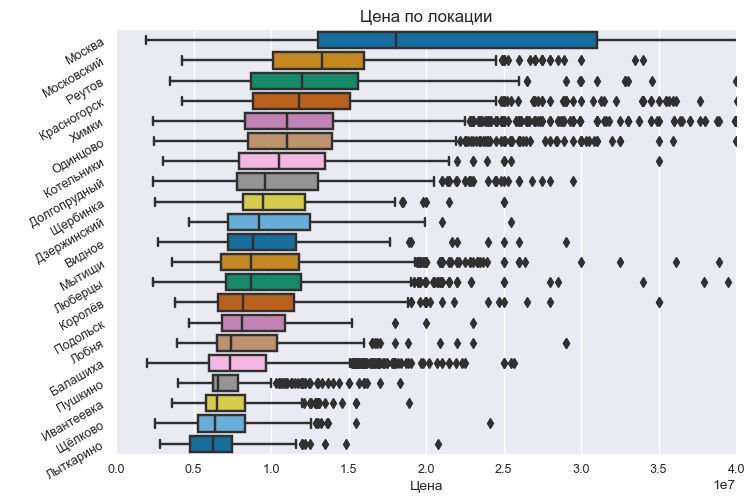

In [52]:
median_by = df.groupby(['city'])['price'].median().sort_values(ascending=False) #вычислить медианное значение 
#Params['figure.figsize'] = 8,8
sns.boxplot(data = df, x=df.price, y=df.city, order=median_by.index, palette = 'colorblind').set_title("Цена по локации", fontsize=12) #создать диаграммы, упорядоченные по по убыванию средней

plt.xlabel("Цена", fontsize=10)
plt.ylabel(" ", fontsize=10);
plt.yticks(rotation=30, fontsize=9)
plt.xticks(fontsize=9)
plt.xlim([0,40000000])

plt.show()

In [235]:
df=df.drop(columns=['city','settlement'])

In [155]:
df.isna().sum()

price                  0
lat                    0
lon                    0
total_square           0
rooms                  0
floor                  0
district           23696
area               78930
name                   0
location               0
city_from              0
settlement_from        0
distance               0
price_of_metr          0
dtype: int64

In [236]:
df[['district','area']]=df[['district','area']].fillna("empty")

In [157]:
df.head()

,price,lat,lon,total_square,rooms,floor,district,area,name,location,city_from,settlement_from,distance,price_of_metr
0,63000000,55.778894,37.608844,137.0,3.0,6.0,Тверской район,empty,3-комнатная,Москва,1,0,2.9,459854.014599
1,3250000,55.551025,37.313054,16.7,0.0,1.0,Филимонковское поселение,empty,Студия,Москва,1,0,29.7,194610.778443
2,16004680,55.594802,37.431264,76.0,3.0,6.0,Сосенское поселение,empty,3-комнатная,Москва,1,0,21.3,210587.894737
3,7841776,55.594332,37.428099,24.0,1.0,10.0,Сосенское поселение,empty,1-комнатная,Москва,1,0,21.5,326740.666667
4,120000000,55.721097,37.464342,126.0,3.0,16.0,Фили-Давыдково район,empty,3-комнатная,Москва,1,0,10.5,952380.952381


# Создаем целевую переменную, делим датасет на выборки

Целевая переменная price

In [237]:
df1=df.copy()

In [238]:
df1.shape

(98421, 14)

In [239]:
#случайная выборка 80% данных для обучени
train_df = df1.sample(frac=0.8, random_state=seed)

In [240]:
#выборка всех данных не входящих в обучение для теста
test_df = df1[~df1['price'].isin(train_df['price'])]

In [241]:
train_df.shape, test_df.shape

((78737, 14), (4891, 14))

In [242]:
train_X = train_df.drop(columns=['price']) 
train_y = train_df['price']

test_X = test_df.drop(columns=['price']) 
test_y = test_df['price']

In [170]:
df.columns

Index(['price', 'lat', 'lon', 'total_square', 'rooms', 'floor', 'district',
       'area', 'name', 'location', 'city_from', 'settlement_from', 'distance',
       'price_of_metr'],
      dtype='object')

In [243]:
#выбераем колонки для использования в виде входных признаков и вписываем ниже в переменную
columns_2_use = ['total_square', 'rooms', 'floor', 'city_from', 'settlement_from','location','district','area','distance','name']
train_X = train_X[columns_2_use]
test_X = test_X[columns_2_use]

In [244]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = train_X.columns[train_X.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    train_X[column] = labelencoder.fit_transform(train_X[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
train_X.info()

{0: 'Балашиха', 1: 'Видное', 2: 'Дзержинский', 3: 'Долгопрудный', 4: 'Ивантеевка', 5: 'Королёв', 6: 'Котельники', 7: 'Красногорск', 8: 'Лобня', 9: 'Лыткарино', 10: 'Люберцы', 11: 'Москва', 12: 'Московский', 13: 'Мытищи', 14: 'Одинцово', 15: 'Подольск', 16: 'Пушкино', 17: 'Реутов', 18: 'Химки', 19: 'Щербинка', 20: 'Щёлково', 21: 'д.\xa0Аристово', 22: 'д.\xa0Болтино', 23: 'д.\xa0Большие Жеребцы', 24: 'д.\xa0Глухово', 25: 'д.\xa0Жабкино', 26: 'д.\xa0Марусино', 27: 'д.\xa0Мисайлово', 28: 'д.\xa0Мотяково', 29: 'д.\xa0Мякинино', 30: 'д.\xa0Островцы', 31: 'д.\xa0Пирогово', 32: 'д.\xa0Подолино', 33: 'д.\xa0Путилково', 34: 'д.\xa0Раздоры', 35: 'д.\xa0Сабурово', 36: 'д.\xa0Сапроново', 37: 'д.\xa0Солманово', 38: 'д.\xa0Сосенки', 39: 'дп.\xa0Красково', 40: 'дп.\xa0Лесной Городок', 41: 'пос.\xa0Битца', 42: 'пос.\xa0ВНИИССОК', 43: 'пос.\xa0Ильинское-Усово', 44: 'пос.\xa0Коммунарка', 45: 'пос.\xa0Марьино', 46: 'пос.\xa0Мебельной фабрики', 47: 'пос.\xa0Мирный', 48: 'пос.\xa0Нагорное', 49: 'пос.\xa0Отр

In [190]:
train_X.head()

,total_square,rooms,floor,city_from,settlement_from,location,district,area,distance,name
3668,41.0,1.0,14.0,1,0,5,0,196,26.0,0
84011,55.5,2.0,10.0,1,0,14,0,165,19.2,7
6554,58.7,2.0,4.0,1,0,11,18,198,22.6,7
33350,40.0,1.0,19.0,1,0,11,34,52,13.0,0
88952,29.0,1.0,1.0,1,0,11,47,52,14.2,0


In [245]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = test_X.columns[test_X.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    test_X[column] = labelencoder.fit_transform(test_X[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
test_X.info()

{0: 'Балашиха', 1: 'Видное', 2: 'Дзержинский', 3: 'Долгопрудный', 4: 'Ивантеевка', 5: 'Королёв', 6: 'Котельники', 7: 'Красногорск', 8: 'Лыткарино', 9: 'Люберцы', 10: 'Москва', 11: 'Московский', 12: 'Мытищи', 13: 'Одинцово', 14: 'Подольск', 15: 'Пушкино', 16: 'Реутов', 17: 'Химки', 18: 'Щёлково', 19: 'д.\xa0Болтино', 20: 'д.\xa0Глухово', 21: 'д.\xa0Жабкино', 22: 'д.\xa0Марусино', 23: 'д.\xa0Мякинино', 24: 'д.\xa0Пирогово', 25: 'д.\xa0Путилково', 26: 'д.\xa0Раздоры', 27: 'д.\xa0Сабурово', 28: 'д.\xa0Сапроново', 29: 'д.\xa0Солманово', 30: 'д.\xa0Сосенки', 31: 'пос.\xa0Битца', 32: 'пос.\xa0Ильинское-Усово', 33: 'пос.\xa0Коммунарка', 34: 'пос.\xa0Марьино', 35: 'пос.\xa0Мирный', 36: 'пос.\xa0Нагорное', 37: 'пос.\xa0Развилка', 38: 'рп.\xa0Дрожжино', 39: 'рп.\xa0Заречье', 40: 'рп.\xa0Лопатино', 41: 'рп.\xa0Нахабино', 42: 'рп.\xa0Новоивановское', 43: 'рп.\xa0Октябрьский', 44: 'рп.\xa0Томилино', 45: 'с.\xa0Немчиновка', 46: 'с.\xa0Николо-Урюпино'}
{0: 'empty', 1: 'Академический район', 2: 'Алексе

# Модель Random forest

In [246]:
# Объявили модель
rf_model_regression = RandomForestRegressor(max_depth=20, random_state=0)

# Обучили модель на тренировочной выборке 
rf_model_regression.fit(train_X, train_y)

# Сделали прогнозы на тестовой выборке 
y_pred_reg_rf = rf_model_regression.predict(test_X)

In [247]:
def mean_absolute_percentage_error(test_y, y_pred_regr): 
    test_y, y_pred_regr = np.array(test_y), np.array(y_pred_regr)
    return np.mean(np.abs((test_y - y_pred_regr) / test_y)) * 100


def results_dict(test_y, y_pred_regr):
    print('MAE:', metrics.mean_absolute_error(test_y, y_pred_regr))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_regr)))
    print('R2:',  metrics.r2_score(test_y, y_pred_regr))
    print('MAPE:', mean_absolute_percentage_error(test_y, y_pred_regr))
    pass

In [248]:
results_dict(test_y,y_pred_reg_rf)

MAE: 5311254.827434153
RMSE: 13354413.631131243
R2: 0.8700705056950424
MAPE: 15.687943621513082


# GradientBoostingRegressor

In [249]:
# Объявили модель
gb_model = GradientBoostingRegressor(random_state=42)

# Обучили модель на тренировочной выборке 
gb_model.fit(train_X, train_y)

# Сделали прогнозы на тестовой выборке 
y_pred_regr_gb = gb_model.predict(test_X)

In [250]:
def mean_absolute_percentage_error(test_y, y_pred_regr): 
    test_y, y_pred_regr = np.array(test_y), np.array(y_pred_regr)
    return np.mean(np.abs((test_y - y_pred_regr) / test_y)) * 100


def results_dict(test_y, y_pred_regr):
    print('MAE:', metrics.mean_absolute_error(test_y, y_pred_regr))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_regr)))
    print('R2:',  metrics.r2_score(test_y, y_pred_regr))
    print('MAPE:', mean_absolute_percentage_error(test_y, y_pred_regr))
    pass

In [251]:
results_dict(test_y,y_pred_regr_gb)

MAE: 6145503.035034527
RMSE: 14719633.521116491
R2: 0.842147270604795
MAPE: 18.197108161252874


Целевая переменная price_of_metr

In [252]:
df2=df.copy()

In [253]:
train_df = df2.sample(frac=0.8, random_state=seed)
test_df = df2[~df2['price_of_metr'].isin(train_df['price_of_metr'])]
train_X = train_df.drop(columns=['price_of_metr']) 
train_y = train_df['price_of_metr']

test_X = test_df.drop(columns=['price_of_metr']) 
test_y = test_df['price_of_metr']
#выбераем колонки для использования в виде входных признаков и вписываем ниже в переменную
columns_2_use = ['total_square', 'rooms', 'floor', 'city_from', 'settlement_from','location','district','area','distance','name']
train_X = train_X[columns_2_use]
test_X = test_X[columns_2_use]
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = train_X.columns[train_X.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    train_X[column] = labelencoder.fit_transform(train_X[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
train_X.info()
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = test_X.columns[test_X.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    test_X[column] = labelencoder.fit_transform(test_X[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
test_X.info()
# Объявили модель
rf_model_regression = RandomForestRegressor(max_depth=20, random_state=0)

# Обучили модель на тренировочной выборке 
rf_model_regression.fit(train_X, train_y)

# Сделали прогнозы на тестовой выборке 
y_pred_reg_rf = rf_model_regression.predict(test_X)
def mean_absolute_percentage_error(test_y, y_pred_regr): 
    test_y, y_pred_regr = np.array(test_y), np.array(y_pred_regr)
    return np.mean(np.abs((test_y - y_pred_regr) / test_y)) * 100


def results_dict(test_y, y_pred_regr):
    print('MAE:', metrics.mean_absolute_error(test_y, y_pred_regr))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_regr)))
    print('R2:',  metrics.r2_score(test_y, y_pred_regr))
    print('MAPE:', mean_absolute_percentage_error(test_y, y_pred_regr))
    pass

{0: 'Балашиха', 1: 'Видное', 2: 'Дзержинский', 3: 'Долгопрудный', 4: 'Ивантеевка', 5: 'Королёв', 6: 'Котельники', 7: 'Красногорск', 8: 'Лобня', 9: 'Лыткарино', 10: 'Люберцы', 11: 'Москва', 12: 'Московский', 13: 'Мытищи', 14: 'Одинцово', 15: 'Подольск', 16: 'Пушкино', 17: 'Реутов', 18: 'Химки', 19: 'Щербинка', 20: 'Щёлково', 21: 'д.\xa0Аристово', 22: 'д.\xa0Болтино', 23: 'д.\xa0Большие Жеребцы', 24: 'д.\xa0Глухово', 25: 'д.\xa0Жабкино', 26: 'д.\xa0Марусино', 27: 'д.\xa0Мисайлово', 28: 'д.\xa0Мотяково', 29: 'д.\xa0Мякинино', 30: 'д.\xa0Островцы', 31: 'д.\xa0Пирогово', 32: 'д.\xa0Подолино', 33: 'д.\xa0Путилково', 34: 'д.\xa0Раздоры', 35: 'д.\xa0Сабурово', 36: 'д.\xa0Сапроново', 37: 'д.\xa0Солманово', 38: 'д.\xa0Сосенки', 39: 'дп.\xa0Красково', 40: 'дп.\xa0Лесной Городок', 41: 'пос.\xa0Битца', 42: 'пос.\xa0ВНИИССОК', 43: 'пос.\xa0Ильинское-Усово', 44: 'пос.\xa0Коммунарка', 45: 'пос.\xa0Марьино', 46: 'пос.\xa0Мебельной фабрики', 47: 'пос.\xa0Мирный', 48: 'пос.\xa0Нагорное', 49: 'пос.\xa0Отр

In [256]:
results_dict(test_y,y_pred_reg_rf)

MAE: 34770.814409753955
RMSE: 59851.05852722049
R2: 0.8889146462945601
MAPE: 10.077950836049965


In [259]:
# Объявили модель

gb_model = GradientBoostingRegressor(random_state=42)

# Обучили модель на тренировочной выборке 
gb_model.fit(train_X, train_y)

# Сделали прогнозы на тестовой выборке 
y_pred_regr_gb = gb_model.predict(test_X)
def mean_absolute_percentage_error(test_y, y_pred_regr): 
    test_y, y_pred_regr = np.array(test_y), np.array(y_pred_regr)
    return np.mean(np.abs((test_y - y_pred_regr) / test_y)) * 100


def results_dict(test_y, y_pred_regr):
    print('MAE:', metrics.mean_absolute_error(test_y, y_pred_regr))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred_regr)))
    print('R2:',  metrics.r2_score(test_y, y_pred_regr))
    print('MAPE:', mean_absolute_percentage_error(test_y, y_pred_regr))
  
    pass

In [260]:
results_dict(test_y,y_pred_regr_gb)

MAE: 57888.38042897221
RMSE: 91131.9503864602
R2: 0.7424542065845603
MAPE: 15.914057636692066
SMAPE: 3.9892427397555124


ИТОГО:
В данном ноутбуке был продемонстрирован быстрый pipeline решения здачи прогнозирования цен на квартиры
, были сгенерированы фичи,проведена очистка.

В первых двух моделях использовала целевую переменную price, результаты не приемлемые.
Во вторых двух моделях в качестве целевой использовала цену за квадратный метр. Модель randomforest показала себя лучше.
В итоге был получен результат на тестовой выборке MAE 34710, это говорит о том,что модель  ошибается в среднем на эту сумму. По сравнению с медианным значением цены перепродажи набора данных MAE относительно очень мал, поскольку составляет меньше 0,5% 